In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import seaborn as sns
import pandas as pd
import gensim
import nltk
import re
import string
import networkx as nx
from curses.ascii import isprint

In [3]:
stop_words = open('stop_words').read().split('\n')[:-1]
#stop_words = 'the,for,to,you,call,that'.split(',')
#print stop_words

In [4]:
emails_table = pd.read_csv("data/emails/Emails.csv").dropna()
person_table = pd.read_csv("data/emails/Persons.csv").dropna()
alias_table = pd.read_csv("data/emails/Aliases.csv").dropna()
email_rec_table = pd.read_csv("data/emails/EmailReceivers.csv").dropna()

In [5]:
corpus = gensim.corpora.MmCorpus('models/corpus.mm')
dictionary = gensim.corpora.Dictionary.load('models/dictionary.dict')
lda = gensim.models.LdaModel.load('models/emails_lda.model')

In [6]:
print len(emails_table)
print len(person_table)
print len(alias_table)
print len(email_rec_table)

908
513
850
9306


In [7]:
emails_table['doc'] = emails_table["ExtractedSubject"] + " " + emails_table["ExtractedBodyText"]

In [8]:
def clean_text(text):
    ot = text
    # Remove any beginning or ending whitespace
    text.strip()
    # Combine conjunctions
    text = re.sub(r"'", "", text)
    # Replace punctuation with space
    text = text.translate(string.maketrans(string.punctuation,''.join(" " for char in string.punctuation)))
    # Replace all control characters
    text = ''.join(char if isprint(char) else " " for char in text)
    # Remove Digits
    text = re.sub(r"[0-9]", " ", text)
    
    
    text = text.lower()
    text_list = [token for token in text.split() if token not in stop_words and len(token) > 1]
    return text_list

In [9]:
emails_table['token_list'] = emails_table['doc'].apply(lambda s: clean_text(s))

In [10]:
person_IDs = list(set(emails_table['MetadataCaseNumber']))
id2docs = {}
for pid in person_IDs:
    id2docs[pid] = list(emails_table[emails_table['MetadataCaseNumber'] == pid]['token_list'])

In [11]:
print dictionary.num_docs
print dictionary.num_pos
print dictionary.num_nnz

908
9603
8734


In [12]:
nt = 98
#only edges with weights above this threshold will be included.
w_thresh = .000000000005
#initialize complete matrix of empty weights. this probably isn't necessary
weights = np.zeros((len(person_IDs),nt))
#for each person
for i in range(len(person_IDs)):
    #for each document the person wrote
    for sublist in id2docs[person_IDs[i]]:
        #get any topics with probability higher than w_thresh for that document
        vals = lda.get_document_topics(dictionary.doc2bow(item for item in sublist),w_thresh)
        for pair in vals:
            weights[i][pair[0]] += pair[1]/len(id2docs[person_IDs[i]])

In [13]:
bip = nx.Graph()
bip.add_nodes_from([(item, {'color':'blue','label':'cvbsdf'}) for item in person_IDs])

In [14]:
for i in range(len(person_IDs)):
    for j in range(nt):
        if weights[i][j] > .006:
            bip.add_node(j, {'color':'red','label':i})
            bip.add_edge(person_IDs[i], j, {'weight':20*weights[i][j]})

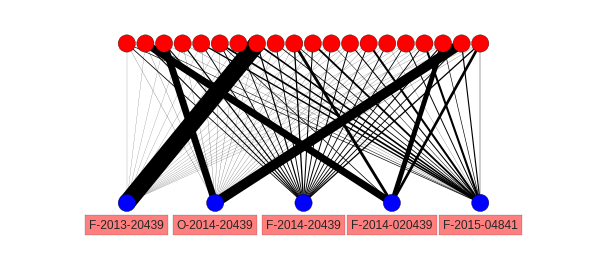

In [24]:
pos=dict()

pos.update( (n, (i*(nt/len(person_IDs)), 1)) for i, n in enumerate(person_IDs) )
pos.update( (i, (4*i, 1.25)) for i in range(nt) )

edges = bip.edges()
nod = bip.nodes()
weights2 = [bip[u][v]['weight'] for u,v in edges]
cols = [bip.node[v]['color'] for v in nod]
plt.figure(num=None, figsize=(10, 4), dpi=1200)
for i, item in enumerate(person_IDs):
    x,y = (i*(nt/len(person_IDs)), 1)
    plt.text(x,y-0.04,s=item, bbox=dict(facecolor='red', alpha=0.5),horizontalalignment='center')
nx.draw(bip, pos=pos, node_color=cols, edges=edges, width=weights2, scale=20, font_size=16)
plt.savefig('foia.png')
#networkx.draw_networkx_labels(bip, pos, lab)

In [28]:
[dictionary[item[0]] for item in lda.get_topic_terms(7, 3)]

[u'print', u'time', u'meet']